<a href="https://colab.research.google.com/github/Bnzxccc/Hand-writing-verification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://@github.com/Bnzxccc/Hand-writing-verification.git

fatal: destination path 'Hand-writing-verification' already exists and is not an empty directory.


In [ ]:
!pip uninstall tensorflow tensorflow-io -y
!pip install tensorflow==2.16.1 tensorflow-io==0.37.1

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
Found existing installation: tensorflow-io 0.37.1
Uninstalling tensorflow-io-0.37.1:
  Successfully uninstalled tensorflow-io-0.37.1
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached tensorflow_io-0.37.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
Using cached tensorflow_io-0.37.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.15.0 requires tensorflow<2.16,>=2.15.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 

In [ ]:
import tensorflow as tf
print("GPU:", tf.config.list_logical_devices('TPU'))
print("Num GPUs:", len(tf.config.list_logical_devices('TPU')))

GPU: []
Num GPUs: 0


In [ ]:
!pip install --ignore-installed blinker

  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)


In [ ]:
!pip install mlflow

In [ ]:
import sys
import os

repo_path = "/content/Hand-writing-verification"
sys.path.append(repo_path)

In [ ]:
from scripts.data_processing import TripletGenerator, MapFunction
from scripts.siamese_model import EmbeddingModule, SiameseModel
from scripts.display_samples import display_triplets
import mlflow
import tensorflow as tf
from tensorflow import keras
import json

config_path = "/content/Hand-writing-verification/scripts/config.json"
with open(config_path, "r") as file:
    config = json.load(file)

In [ ]:
trainTripletGenerator = TripletGenerator(
    datasetPath = '/content/Hand-writing-verification/' + config['train_data_path'])
valTripletGenerator = TripletGenerator(
    datasetPath = '/content/Hand-writing-verification/' + config['train_data_path'])

raw_train_ds = tf.data.Dataset.from_generator(
    trainTripletGenerator,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
)

raw_val_ds = tf.data.Dataset.from_generator(
    valTripletGenerator,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
)

map_function = MapFunction(imageSize = tuple(config['image_size']))

train_ds = raw_train_ds.map(map_function).batch(config['batch_size']).prefetch(tf.data.AUTOTUNE)
val_ds = raw_val_ds.map(map_function).batch(config['batch_size']).prefetch(tf.data.AUTOTUNE)

In [ ]:
embedder = EmbeddingModule(imageSize = tuple(config['image_size']))
siamese_network = SiameseModel(
    imageSize = tuple(config['image_size']),
    embedder = embedder,
    margin = config['margin'],
    lossTracker = keras.metrics.Mean(name = 'loss'))

In [ ]:
embedder.summary()

Model: "Embedding_Module"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 10, 10, 2048)        │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,780,160 (94.53 MB)

 Trainable params: 1,214,336 (4.63 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

In [ ]:
siamese_network.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Siamese_Network (Functional)         │ ((None, 128), (None, 128),  │      24,780,160 │
│                                      │ (None, 128))                │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,780,160 (94.53 MB)

 Trainable params: 1,214,336 (4.63 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

In [ ]:
siamese_network.compile(optimizer = keras.optimizers.Adam(config['learning_rate']))

Anchor shape: (300, 300, 3)


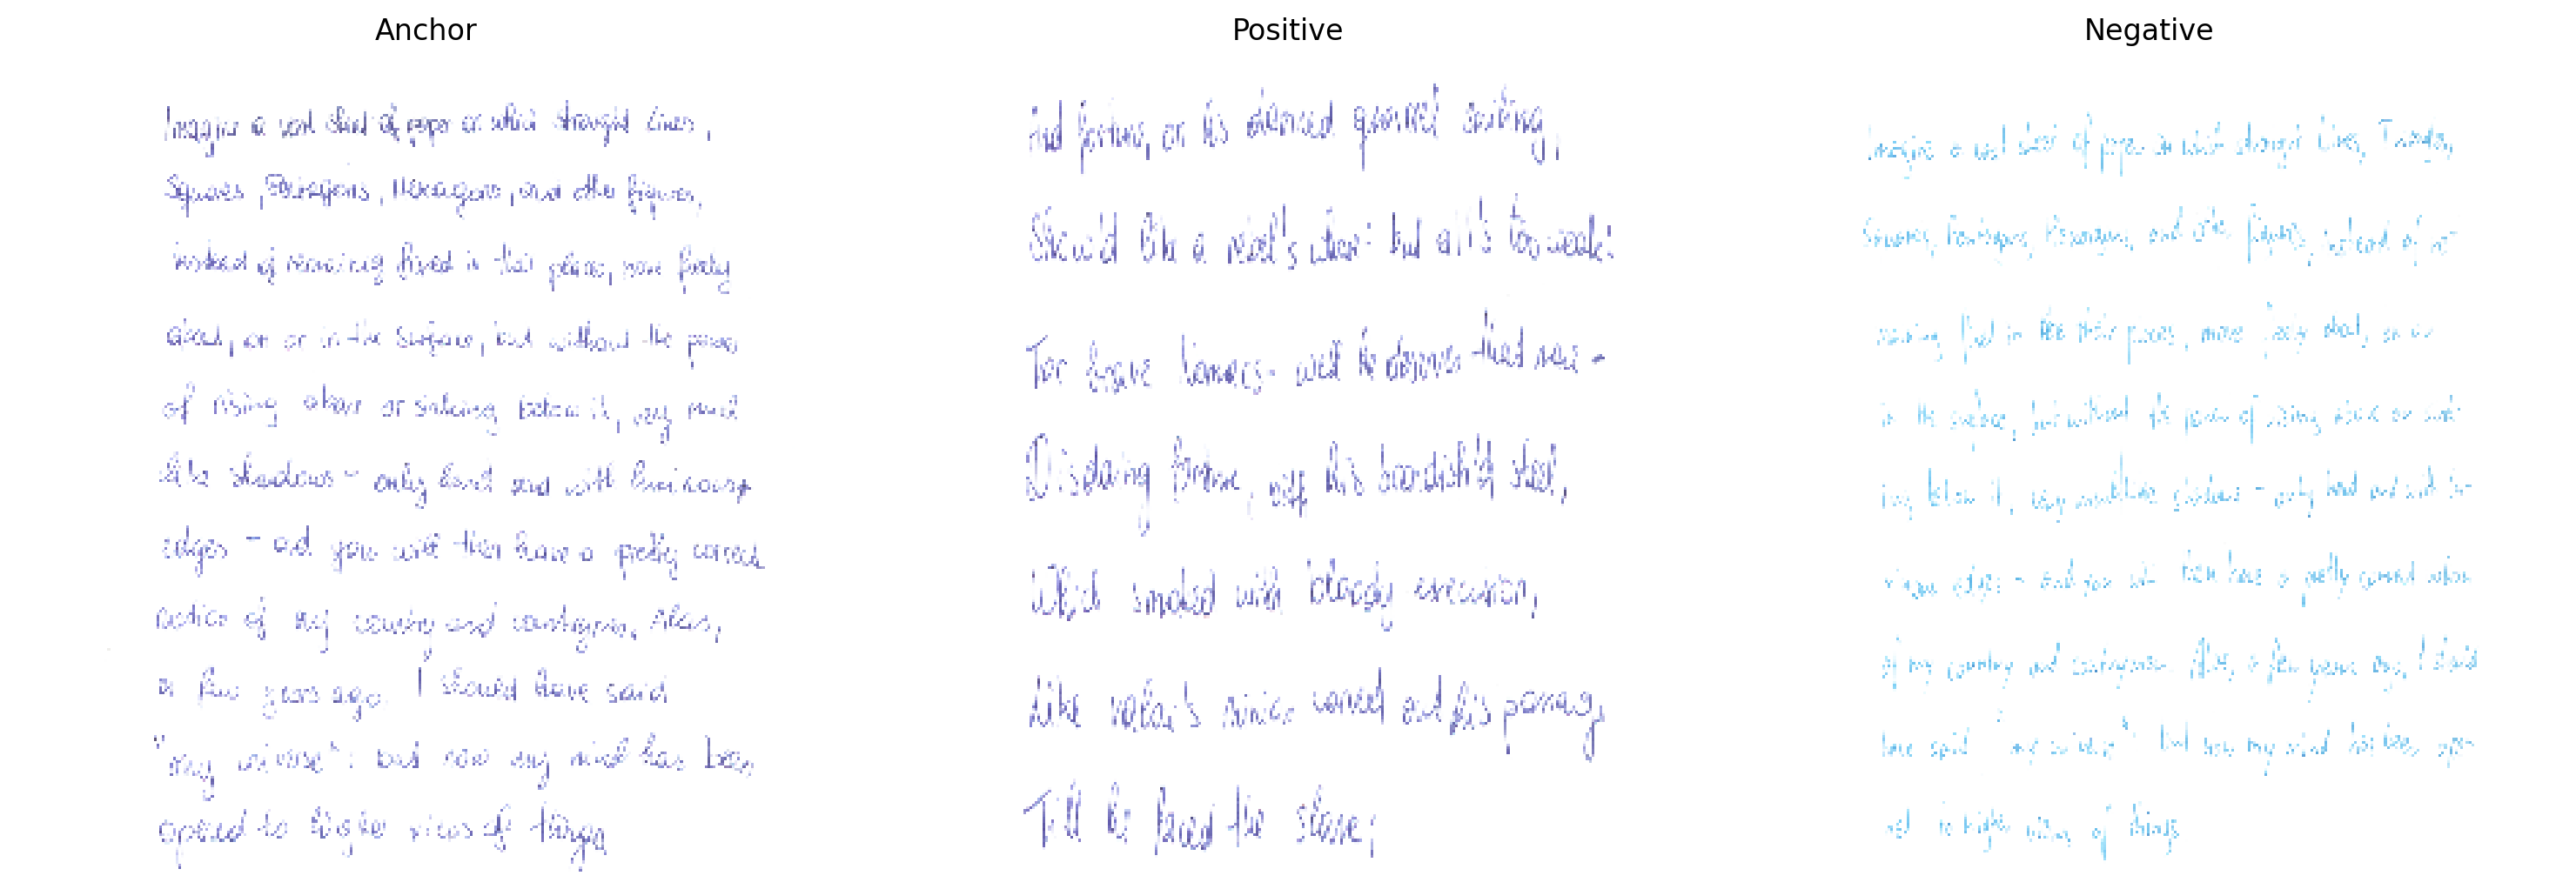

In [ ]:
display_triplets(train_ds)

In [ ]:
a, p, n = next(iter(train_ds))

In [ ]:
anchor_embedding = embedder(a)
positive_embedding = embedder(p)
negative_embedding = embedder(n)

anchor_embedding.shape, positive_embedding.shape, negative_embedding.shape


(TensorShape([64, 128]), TensorShape([64, 128]), TensorShape([64, 128]))

In [ ]:


history = siamese_network.fit(
    train_ds,
    epochs = config['n_epochs'],
    steps_per_epoch = config['steps_per_epoch'],
    validation_data = val_ds,
    validation_steps = config['validation_steps']
)

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1782s 6s/step - loss: 0.0825 - val_loss: 0.0344
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1785s 6s/step - loss: 0.0328 - val_loss: 0.0189
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1795s 6s/step - loss: 0.0228 - val_loss: 0.0195
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1807s 6s/step - loss: 0.0183 - val_loss: 0.0152
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1812s 6s/step - loss: 0.0133 - val_loss: 0.0174
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1806s 6s/step - loss: 0.0140 - val_loss: 0.0081
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1823s 6s/step - loss: 0.0101 - val_loss: 0.0103
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1807s 6s/step - loss: 0.0079 - val_loss: 0.0093
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1807s 6s/step - loss: 0.0074 - val_loss: 0.0079
Epoch 10/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1803s 6s/step - loss: 0.0094 - val_loss: 0.0069


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


keras.models.save_model(
	model=siameseModel.siameseNetwork,
	filepath=modelPath,
	include_optimizer=False,
)
siamese_network.save('/content/drive/MyDrive/Siamese/Model/1-1.keras')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)
